In [168]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [169]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [170]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2196987 entries, 0 to 2196986
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 33.5 MB


# reduce to 1 million events

In [171]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [172]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,27993,0.13,27.993
1,27491,0.13,27.491
2,27684,0.13,27.684
3,27764,0.13,27.764
4,27758,0.13,27.758
...,...,...,...
999995,30510,0.12,30.510
999996,29558,0.12,29.558
999997,29159,0.12,29.159
999998,29351,0.12,29.351


In [173]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [174]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [175]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

25898469616000

### Calcul de la date de base = now - cumul_interval

In [176]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 12, 14, 33, 19, 261843)

In [177]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [178]:
conso_data.iloc[0]


Interval     27993.000000
kWh              0.130000
sec             27.993000
Wh             128.603579
cumul(ms)    27993.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [179]:
base

datetime.datetime(2024, 7, 12, 14, 33, 19, 261843)

## créer les dates

In [180]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-12 14:33:47.254843
1        2024-07-12 14:34:14.745843
2        2024-07-12 14:34:42.429843
3        2024-07-12 14:35:10.193843
4        2024-07-12 14:35:37.951843
                    ...            
999995   2025-05-08 08:32:32.304843
999996   2025-05-08 08:33:01.862843
999997   2025-05-08 08:33:31.021843
999998   2025-05-08 08:34:00.372843
999999   2025-05-08 08:34:28.877843
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [181]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,27993,0.13,27.993,128.603579,27993,2024-07-12 14:33:47.254843,12/07/24
1,27491,0.13,27.491,130.951948,55484,2024-07-12 14:34:14.745843,12/07/24
2,27684,0.13,27.684,130.039012,83168,2024-07-12 14:34:42.429843,12/07/24
3,27764,0.13,27.764,129.664313,110932,2024-07-12 14:35:10.193843,12/07/24
4,27758,0.13,27.758,129.692341,138690,2024-07-12 14:35:37.951843,12/07/24
...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25


### save conso_data with dates

In [182]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [183]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('08/05/25', 8, 5, 2025, '08:34:43')

In [184]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [185]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 999058 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   942 non-null    int64         
 1   kWh        942 non-null    float64       
 2   sec        942 non-null    float64       
 3   Wh         942 non-null    float64       
 4   cumul(ms)  942 non-null    int64         
 5   dates      942 non-null    datetime64[ns]
 6   days       942 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 58.9+ KB


In [186]:
end = time.time()
print(end - start)

18.92255926132202


### grouped by days

In [187]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [188]:
data = list(df_grp['kWh'])
print(data)

[1.468, 3.534, 3.555, 3.767, 3.448, 3.444, 3.276, 3.477, 3.281, 3.722, 3.568, 3.69, 3.591, 3.435, 3.257, 3.181, 2.851, 3.049, 3.608, 3.81, 3.851, 3.001, 3.331, 3.35, 3.504, 3.659, 3.488, 3.664, 3.802, 3.861, 3.665, 4.374, 4.304, 3.895, 3.894, 4.037, 3.8, 3.848, 3.698, 3.293, 3.923, 3.944, 4.445, 3.776, 4.115, 3.795, 3.968, 3.778, 3.963, 3.663, 3.647, 3.5, 3.67, 3.513, 4.136, 3.716, 3.446, 3.548, 3.242, 2.444, 1.795, 1.792, 1.794, 1.796, 2.483, 1.855, 1.787, 1.791, 1.791, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.795, 1.803, 1.795, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.795, 3.997, 3.648, 3.922, 3.088, 3.598, 4.003, 3.447, 3.377, 3.96, 3.341, 4.168, 3.081, 4.038, 3.145, 3.357, 3.486, 4.001, 3.294, 3.368, 3.824, 3.226, 3.544, 3.353, 3.867, 3.402, 3.767, 3.31, 4.468, 3.669, 3.82, 3.473, 4.091, 3.488, 3.419, 3.508, 3.668, 3.735, 4.058, 3.546, 3.477, 3.687, 3.154, 3

In [189]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [190]:
end = time.time()
print(end - start)

19.670581102371216


### plot function by day
#### show('dd/mm/yy')

In [191]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


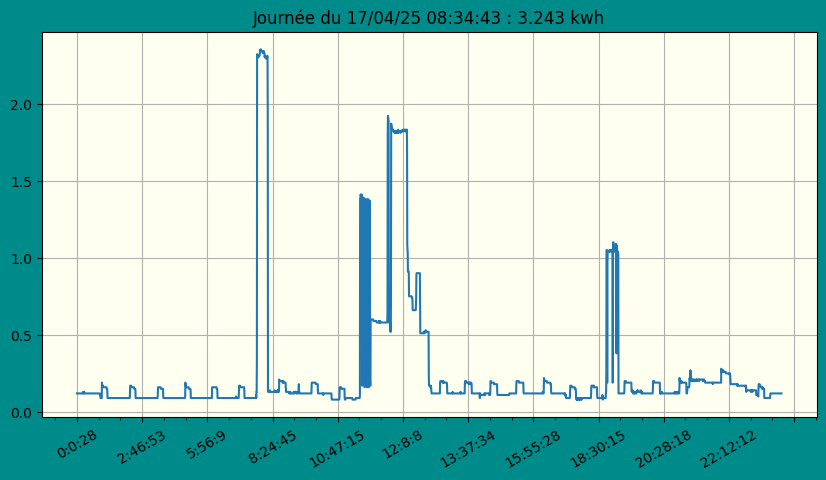

In [192]:
show('17/04/25')

In [193]:
end = time.time()
print(end - start)

21.09249997138977


### 1 kWh window in data of one day
#### df = conso_day

In [194]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999058,27664,0.13,27.664,130.133025,25867618645,2025-05-08 00:00:17.906843,08/05/25
999059,26820,0.13,26.820,134.228188,25867645465,2025-05-08 00:00:44.726843,08/05/25
999060,27298,0.13,27.298,131.877793,25867672763,2025-05-08 00:01:12.024843,08/05/25
999061,28137,0.13,28.137,127.945410,25867700900,2025-05-08 00:01:40.161843,08/05/25
999062,28374,0.13,28.374,126.876718,25867729274,2025-05-08 00:02:08.535843,08/05/25
...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25


In [195]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [196]:
df = conso_day
len(df)

942

In [197]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-08 00:00:17.906843	2025-05-08 08:34:28.877843	8h 34m 10s 	942


In [198]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.299526
dtype: float64

In [199]:
end = time.time()
print(end - start)

21.43851327896118


## mean for data grouped by days

In [200]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.322259
dtype: float64

In [201]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.942)

# conso by date


In [202]:
# select day
day = today

#day = '16/08/24'
day

'08/05/25'

In [203]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999058,27664,0.13,27.664,130.133025,25867618645,2025-05-08 00:00:17.906843,08/05/25
999059,26820,0.13,26.820,134.228188,25867645465,2025-05-08 00:00:44.726843,08/05/25
999060,27298,0.13,27.298,131.877793,25867672763,2025-05-08 00:01:12.024843,08/05/25
999061,28137,0.13,28.137,127.945410,25867700900,2025-05-08 00:01:40.161843,08/05/25
999062,28374,0.13,28.374,126.876718,25867729274,2025-05-08 00:02:08.535843,08/05/25
...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25


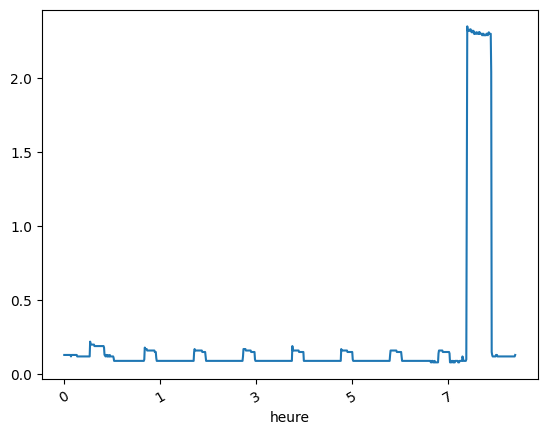

In [204]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [205]:
end = time.time()
print(end - start)

22.024807929992676


### grouped by 'heure'

In [206]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 999058 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   942 non-null    int64         
 1   kWh        942 non-null    float64       
 2   sec        942 non-null    float64       
 3   Wh         942 non-null    float64       
 4   cumul(ms)  942 non-null    int64         
 5   dates      942 non-null    datetime64[ns]
 6   days       942 non-null    object        
 7   heure      942 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 66.2+ KB


In [207]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999058,27664,0.13,27.664,130.133025,25867618645,2025-05-08 00:00:17.906843,08/05/25
999059,26820,0.13,26.820,134.228188,25867645465,2025-05-08 00:00:44.726843,08/05/25
999060,27298,0.13,27.298,131.877793,25867672763,2025-05-08 00:01:12.024843,08/05/25
999061,28137,0.13,28.137,127.945410,25867700900,2025-05-08 00:01:40.161843,08/05/25
999062,28374,0.13,28.374,126.876718,25867729274,2025-05-08 00:02:08.535843,08/05/25
...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25


In [208]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [209]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    127
1    102
2    101
3    100
4    100
5    100
6     99
7     97
8    116
Name: kWh, dtype: int64

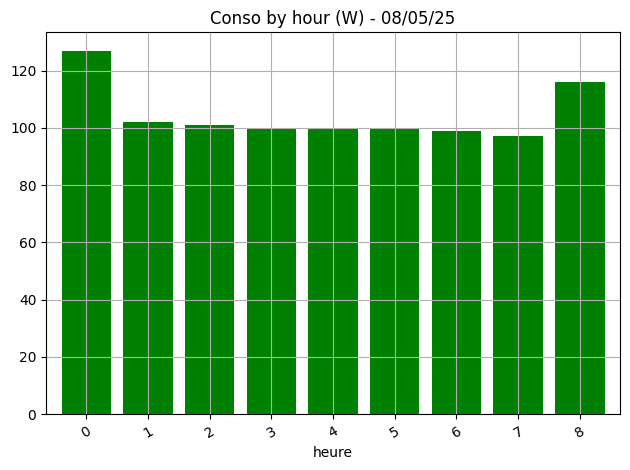

In [210]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [211]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 12/07/24 to 08/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     301 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [212]:
# give the periods of 1 kwh in a day
period()

2025-05-08 00:00:17.906843	2025-05-08 08:34:28.877843	8h 34m 10s 	942


In [213]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [214]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [215]:
df_grp.mean()


kWh    3.322259
dtype: float64

In [216]:
df_grp.head()


,kWh
days,
12/07/24,1.468
13/07/24,3.534
14/07/24,3.555
15/07/24,3.767
16/07/24,3.448


In [217]:
df_grp.tail()


,kWh
days,
04/05/25,3.418
05/05/25,3.150
06/05/25,3.556
07/05/25,3.373
08/05/25,0.942


In [218]:
end = time.time()
print(end - start)

23.114311456680298


# plot les 100 derniers jours


In [219]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.45749
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

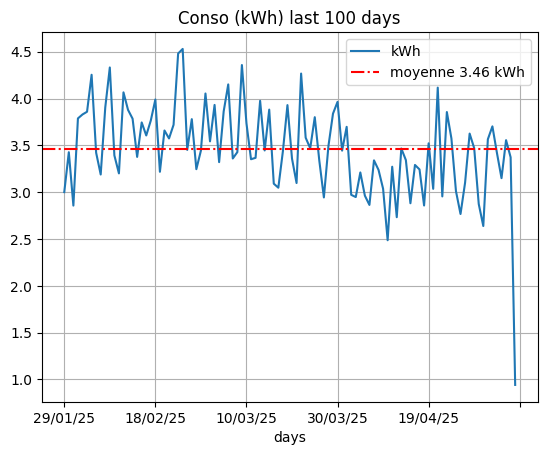

In [220]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [221]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.942
max,4.530


In [222]:
end = time.time()
print(end - start)

23.731788158416748


In [223]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('08/04/25', '03/05/25')

In [224]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.238833
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

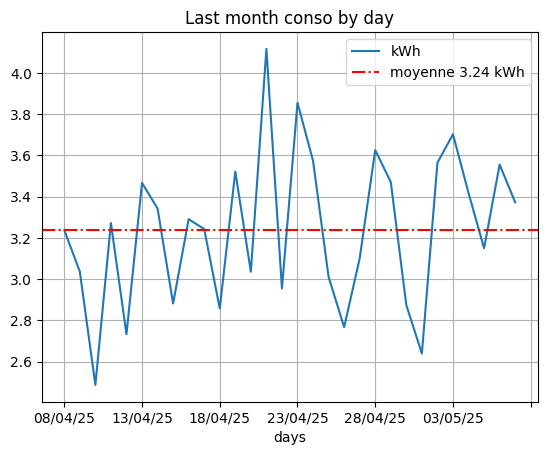

In [225]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [226]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.117
Min : 10/04/25 2.487


# Temps de conso par tranche de 1 kWh

In [227]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


1
2025-05-08 00:00:17.906843	2025-05-08 08:34:28.877843	8h 34m 10s 	942


In [228]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('08:34:43', 0.942, 942)

In [229]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 999058 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   942 non-null    int64         
 1   kWh        942 non-null    float64       
 2   sec        942 non-null    float64       
 3   Wh         942 non-null    float64       
 4   cumul(ms)  942 non-null    int64         
 5   dates      942 non-null    datetime64[ns]
 6   days       942 non-null    object        
 7   heure      942 non-null    object        
 8   hours      942 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 73.6+ KB


In [230]:
conso_hours['heure'], conso_hours['hours']

(999058    0
 999059    0
 999060    0
 999061    0
 999062    0
          ..
 999995    8
 999996    8
 999997    8
 999998    8
 999999    8
 Name: heure, Length: 942, dtype: object,
 999058    00
 999059    00
 999060    00
 999061    00
 999062    00
           ..
 999995    08
 999996    08
 999997    08
 999998    08
 999999    08
 Name: hours, Length: 942, dtype: object)

In [231]:
end = time.time()
print(end - start)

24.461901426315308


# select number of days to display


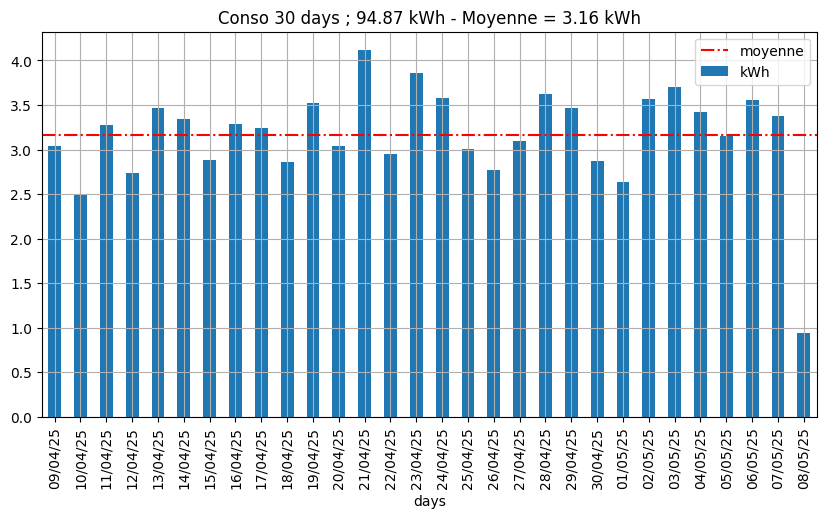

In [232]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


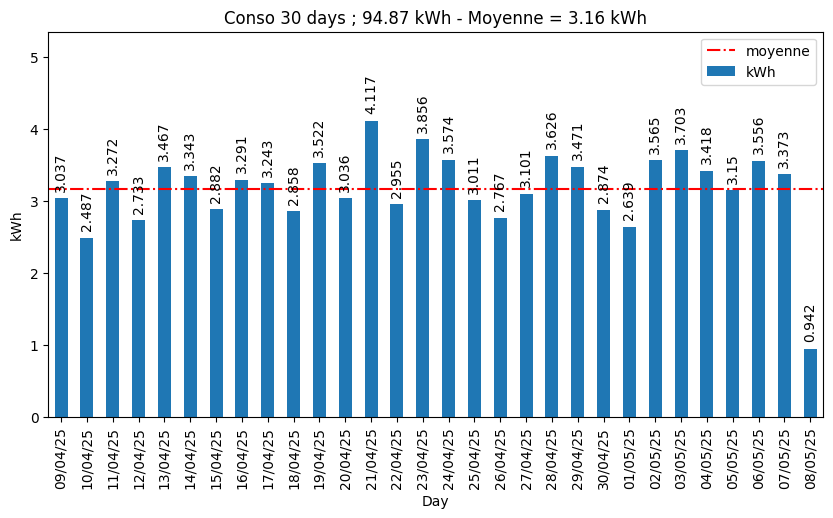

In [233]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [234]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
09/04/25    3.037
10/04/25    2.487
11/04/25    3.272
12/04/25    2.733
13/04/25    3.467
14/04/25    3.343
15/04/25    2.882
16/04/25    3.291
17/04/25    3.243
18/04/25    2.858
19/04/25    3.522
20/04/25    3.036
21/04/25    4.117
22/04/25    2.955
23/04/25    3.856
24/04/25    3.574
25/04/25    3.011
26/04/25    2.767
27/04/25    3.101
28/04/25    3.626
29/04/25    3.471
30/04/25    2.874
01/05/25    2.639
02/05/25    3.565
03/05/25    3.703
04/05/25    3.418
05/05/25    3.150
06/05/25    3.556
07/05/25    3.373
08/05/25    0.942
Name: kWh, dtype: float64

In [235]:
x_labels=df_grp.tail(span).index
x_labels

Index(['09/04/25', '10/04/25', '11/04/25', '12/04/25', '13/04/25', '14/04/25',
       '15/04/25', '16/04/25', '17/04/25', '18/04/25', '19/04/25', '20/04/25',
       '21/04/25', '22/04/25', '23/04/25', '24/04/25', '25/04/25', '26/04/25',
       '27/04/25', '28/04/25', '29/04/25', '30/04/25', '01/05/25', '02/05/25',
       '03/05/25', '04/05/25', '05/05/25', '06/05/25', '07/05/25', '08/05/25'],
      dtype='object', name='days')

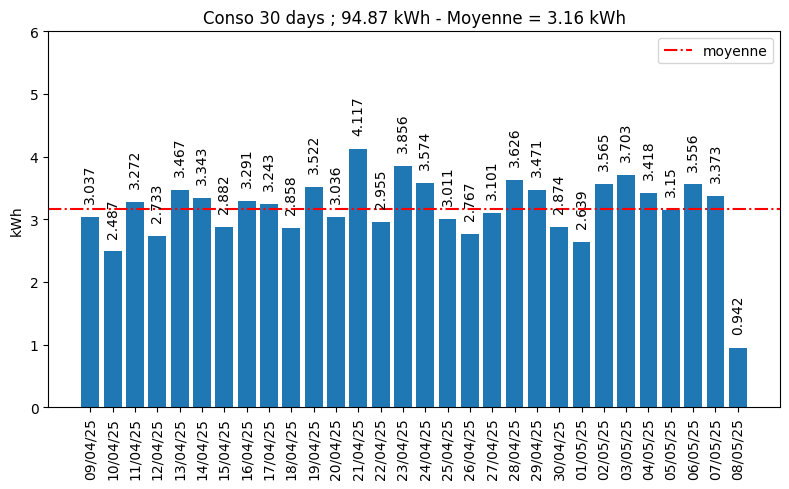

In [236]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [237]:
end = time.time()
print(end - start)

29.34127140045166


In [238]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

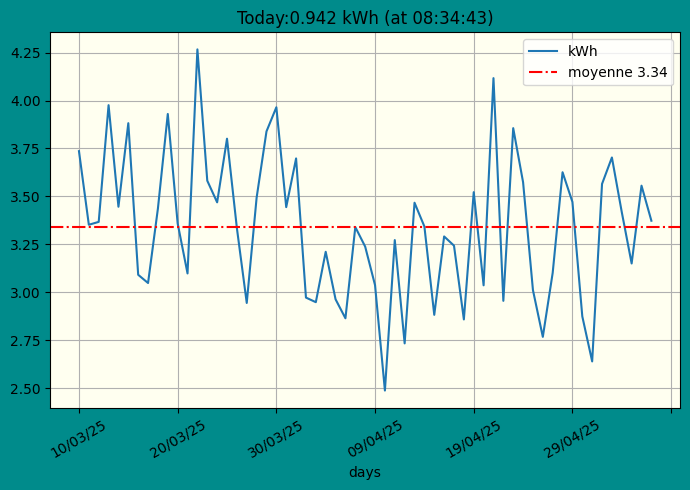

In [239]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

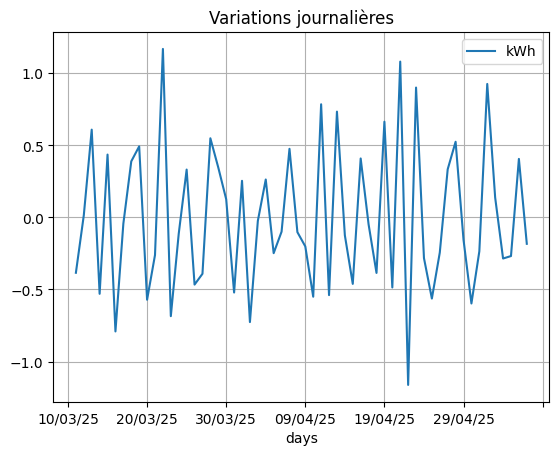

In [240]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [241]:
end = time.time()
print(end - start)

30.904898643493652


# Data from 21/08/23

In [242]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,27993,0.13,27.993,128.603579,27993,2024-07-12 14:33:47.254843,12/07/24,14,2024-07,12
1,27491,0.13,27.491,130.951948,55484,2024-07-12 14:34:14.745843,12/07/24,14,2024-07,12
2,27684,0.13,27.684,130.039012,83168,2024-07-12 14:34:42.429843,12/07/24,14,2024-07,12
3,27764,0.13,27.764,129.664313,110932,2024-07-12 14:35:10.193843,12/07/24,14,2024-07,12
4,27758,0.13,27.758,129.692341,138690,2024-07-12 14:35:37.951843,12/07/24,14,2024-07,12
...,...,...,...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25,08,2025-05,08
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25,08,2025-05,08
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25,08,2025-05,08
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25,08,2025-05,08


In [243]:
end = time.time()
print(end - start)

69.02246308326721


In [244]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

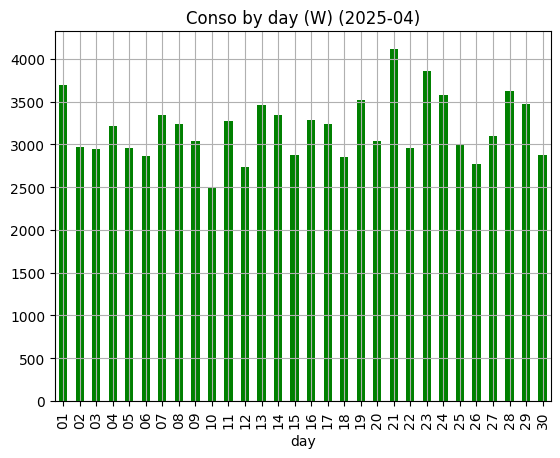

In [245]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [246]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3191.9)

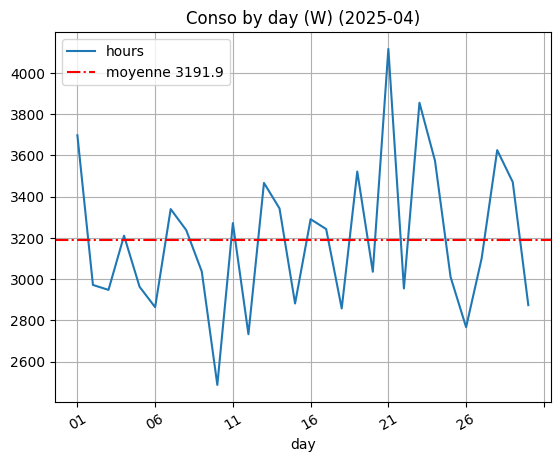

In [247]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [248]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

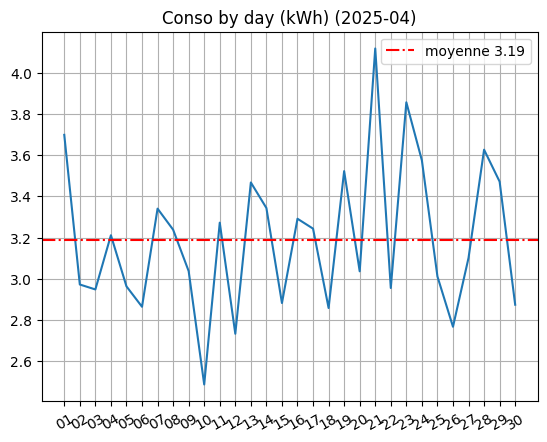

In [249]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [250]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [251]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [252]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,67012,67012,67012
2024-08,117336,117336,117336
2024-09,69781,69781,69781
2024-10,73504,73504,73504
2024-11,108515,108515,108515
2024-12,113755,113755,113755
2025-01,113633,113633,113633
2025-02,104490,104490,104490
2025-03,111871,111871,111871


In [253]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [254]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [255]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
12/07/24,1468
13/07/24,3534
14/07/24,3555
15/07/24,3767
16/07/24,3448
...,...
04/05/25,3418
05/05/25,3150
06/05/25,3556


In [256]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,27993,0.13,27.993,128.603579,27993,2024-07-12 14:33:47.254843,12/07/24,14,2024-07,12
1,27491,0.13,27.491,130.951948,55484,2024-07-12 14:34:14.745843,12/07/24,14,2024-07,12
2,27684,0.13,27.684,130.039012,83168,2024-07-12 14:34:42.429843,12/07/24,14,2024-07,12
3,27764,0.13,27.764,129.664313,110932,2024-07-12 14:35:10.193843,12/07/24,14,2024-07,12
4,27758,0.13,27.758,129.692341,138690,2024-07-12 14:35:37.951843,12/07/24,14,2024-07,12
...,...,...,...,...,...,...,...,...,...,...
999995,30510,0.12,30.510,117.994100,25898353043,2025-05-08 08:32:32.304843,08/05/25,08,2025-05,08
999996,29558,0.12,29.558,121.794438,25898382601,2025-05-08 08:33:01.862843,08/05/25,08,2025-05,08
999997,29159,0.12,29.159,123.461024,25898411760,2025-05-08 08:33:31.021843,08/05/25,08,2025-05,08
999998,29351,0.12,29.351,122.653402,25898441111,2025-05-08 08:34:00.372843,08/05/25,08,2025-05,08


In [257]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
12/07/24 14    0       12/07/24    14  0.13
               1       12/07/24    14  0.13
               2       12/07/24    14  0.13
               3       12/07/24    14  0.13
               4       12/07/24    14  0.13
...                         ...   ...   ...
08/05/25 08    999995  08/05/25    08  0.12
               999996  08/05/25    08  0.12
               999997  08/05/25    08  0.12
               999998  08/05/25    08  0.12
               999999  08/05/25    08  0.13

[1000000 rows x 3 columns]

In [258]:
groupallbyday.indices.keys()

dict_keys(['12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/1

In [259]:
groupallbydayhours.indices.keys()

dict_keys([('12/07/24', '14'), ('12/07/24', '15'), ('12/07/24', '16'), ('12/07/24', '17'), ('12/07/24', '18'), ('12/07/24', '19'), ('12/07/24', '20'), ('12/07/24', '21'), ('12/07/24', '22'), ('12/07/24', '23'), ('13/07/24', '14'), ('13/07/24', '15'), ('13/07/24', '16'), ('13/07/24', '17'), ('13/07/24', '18'), ('13/07/24', '19'), ('13/07/24', '20'), ('13/07/24', '21'), ('13/07/24', '22'), ('13/07/24', '23'), ('13/07/24', '00'), ('13/07/24', '01'), ('13/07/24', '02'), ('13/07/24', '03'), ('13/07/24', '04'), ('13/07/24', '05'), ('13/07/24', '06'), ('13/07/24', '07'), ('13/07/24', '08'), ('13/07/24', '09'), ('13/07/24', '10'), ('13/07/24', '11'), ('13/07/24', '12'), ('13/07/24', '13'), ('14/07/24', '14'), ('14/07/24', '15'), ('14/07/24', '16'), ('14/07/24', '17'), ('14/07/24', '18'), ('14/07/24', '19'), ('14/07/24', '20'), ('14/07/24', '21'), ('14/07/24', '22'), ('14/07/24', '23'), ('14/07/24', '00'), ('14/07/24', '01'), ('14/07/24', '02'), ('14/07/24', '03'), ('14/07/24', '04'), ('14/07/2

In [260]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
12/07/24,1468,1468
13/07/24,3534,3534
14/07/24,3555,3555
15/07/24,3767,3767
16/07/24,3448,3448
...,...,...
04/05/25,3418,3418
05/05/25,3150,3150
06/05/25,3556,3556


In [261]:
grp_by_day['kWh'].cumsum()

days
12/07/24       1468
13/07/24       5002
14/07/24       8557
15/07/24      12324
16/07/24      15772
             ...   
04/05/25     988979
05/05/25     992129
06/05/25     995685
07/05/25     999058
08/05/25    1000000
Name: kWh, Length: 301, dtype: int64

In [262]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
12/07/24 14      57
         15     146
         16     141
         17     285
         18     143
...             ...
08/05/25 04     100
         05     100
         06      99
         07      97
         08     116

[7195 rows x 1 columns]

In [263]:
grp_by_dayhours['kWh'].cumsum()

days      hours
12/07/24  14            57
          15           203
          16           344
          17           629
          18           772
                    ...   
08/05/25  04        999588
          05        999688
          06        999787
          07        999884
          08       1000000
Name: kWh, Length: 7195, dtype: int64

In [264]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
12/07/24 14      57      57    NaN
         15     146     203   89.0
         16     141     344   -5.0
         17     285     629  144.0
         18     143     772 -142.0
...             ...     ...    ...
08/05/25 04     100     530    0.0
         05     100     630    0.0
         06      99     729   -1.0
         07      97     826   -2.0
         08     116     942   19.0

[7195 rows x 3 columns]

In [265]:
today, grp_by_dayhours.loc[today]

('08/05/25',
        kWh  cumsum  diff
 hours                   
 00     127     127   NaN
 01     102     229 -25.0
 02     101     330  -1.0
 03     100     430  -1.0
 04     100     530   0.0
 05     100     630   0.0
 06      99     729  -1.0
 07      97     826  -2.0
 08     116     942  19.0)

Text(0.5, 1.0, 'Cumul journalier')

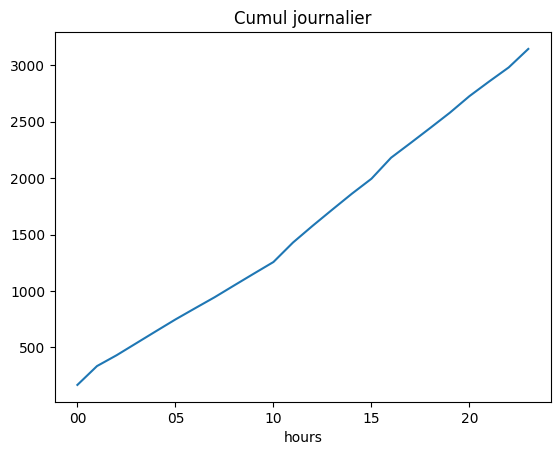

In [266]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

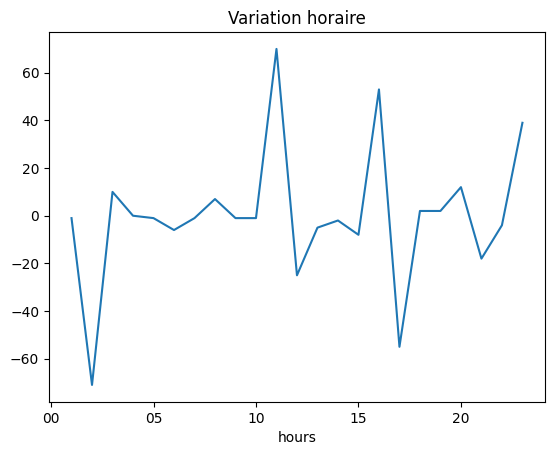

In [267]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [268]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

301

In [269]:
df_grp.tail(n)['kWh'].describe()


count    301.000000
mean       3.322259
std        0.743611
min        0.942000
25%        3.150000
50%        3.469000
75%        3.785000
max        4.805000
Name: kWh, dtype: float64

In [270]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [271]:
n, np.nanmean(df_grp.tail(n))

(301, np.float64(3.3222591362126246))

Text(0.5, 1.0, '301 days')

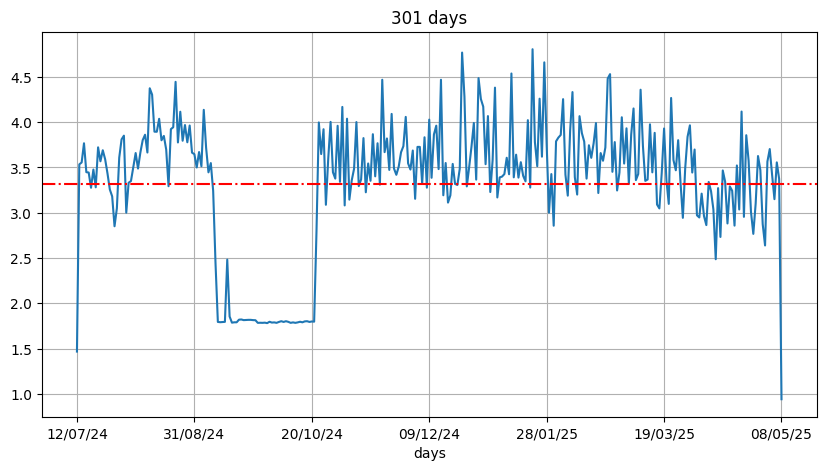

In [272]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

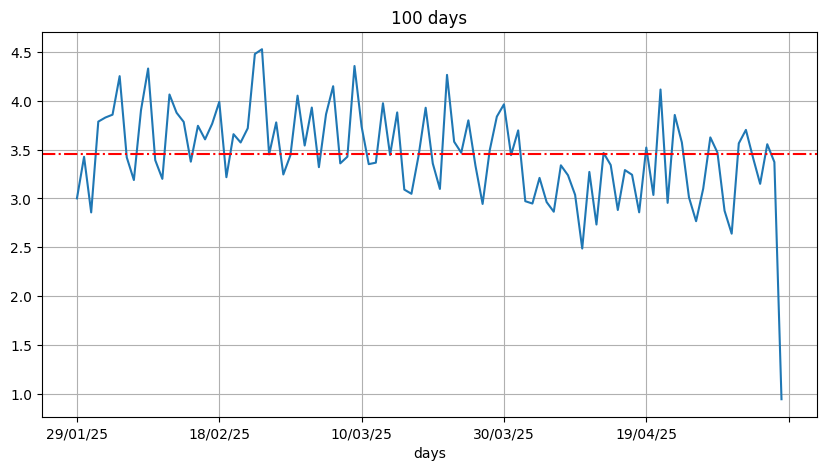

In [273]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [274]:
np.nanmean(df_grp.tail(span))

np.float64(3.457489999999999)

In [275]:
df_grp['kWh']

days
12/07/24    1.468
13/07/24    3.534
14/07/24    3.555
15/07/24    3.767
16/07/24    3.448
            ...  
04/05/25    3.418
05/05/25    3.150
06/05/25    3.556
07/05/25    3.373
08/05/25    0.942
Name: kWh, Length: 301, dtype: float64

In [276]:
df_grp.describe()

,kWh
count,301.000000
mean,3.322259
std,0.743611
min,0.942000
25%,3.150000
50%,3.469000
75%,3.785000
max,4.805000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

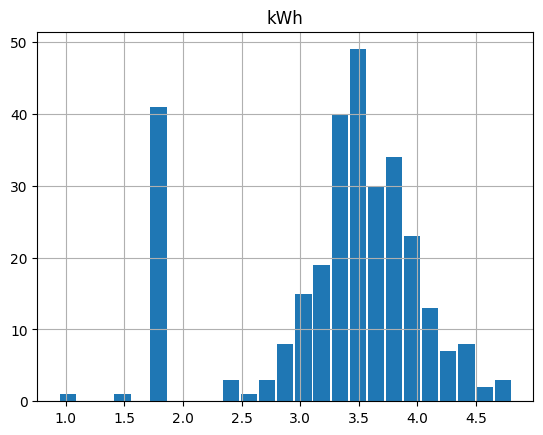

In [277]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [278]:
df_grp.tail(span)['kWh']

days
29/01/25    3.001
30/01/25    3.427
31/01/25    2.857
01/02/25    3.788
02/02/25    3.830
            ...  
04/05/25    3.418
05/05/25    3.150
06/05/25    3.556
07/05/25    3.373
08/05/25    0.942
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [279]:
day

'08/05/25'

In [280]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,127,127,NaN
01,102,229,-25.0
02,101,330,-1.0
03,100,430,-1.0
04,100,530,0.0
05,100,630,0.0
06,99,729,-1.0
07,97,826,-2.0
08,116,942,19.0


In [281]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


9

In [282]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 10)

In [283]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [284]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [285]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [286]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [287]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 00 to 08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     9 non-null      int64  
 1   cumsum  9 non-null      int64  
 2   diff    8 non-null      float64
 3   days    9 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 360.0+ bytes


In [288]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [289]:
day

'08/05/25'

In [290]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,127,127,NaN,1.0
01,102,229,-25.0,2.0
02,101,330,-1.0,3.0
03,100,430,-1.0,4.0
04,100,530,0.0,5.0
05,100,630,0.0,6.0
06,99,729,-1.0,7.0
07,97,826,-2.0,8.0
08,116,942,19.0,9.0


In [291]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_9616\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(942)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '08/05/25: kWh    942\ndtype: int64')

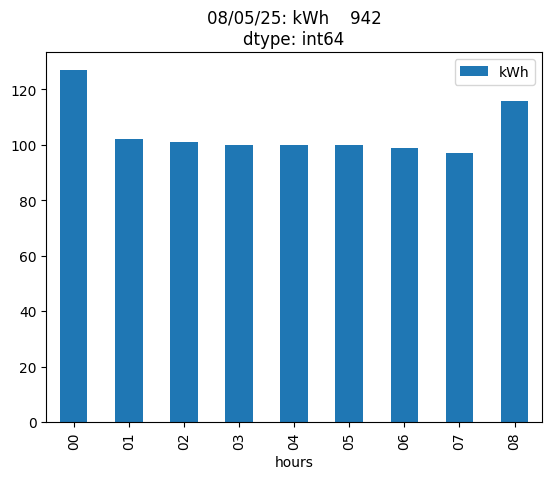

In [292]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [293]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08'], dtype='object', name='hours')

# Conso du jour


In [294]:

grp_by_dayhours.count()

kWh       7195
cumsum    7195
diff      6894
days         9
dtype: int64

'22/01/25'

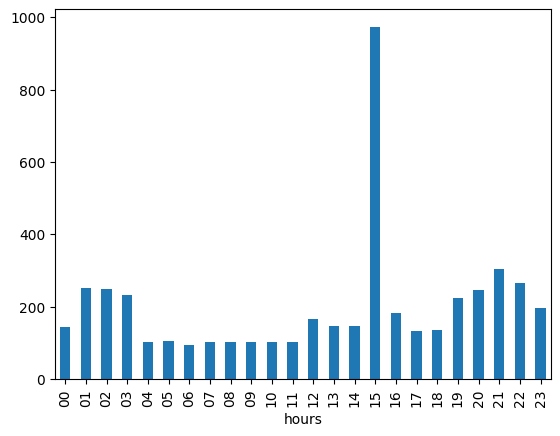

In [295]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [296]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [297]:
df_grp.tail(7)['kWh']

days
02/05/25    3.565
03/05/25    3.703
04/05/25    3.418
05/05/25    3.150
06/05/25    3.556
07/05/25    3.373
08/05/25    0.942
Name: kWh, dtype: float64

Total= 345.749 , Moyenne= 3.457489999999999


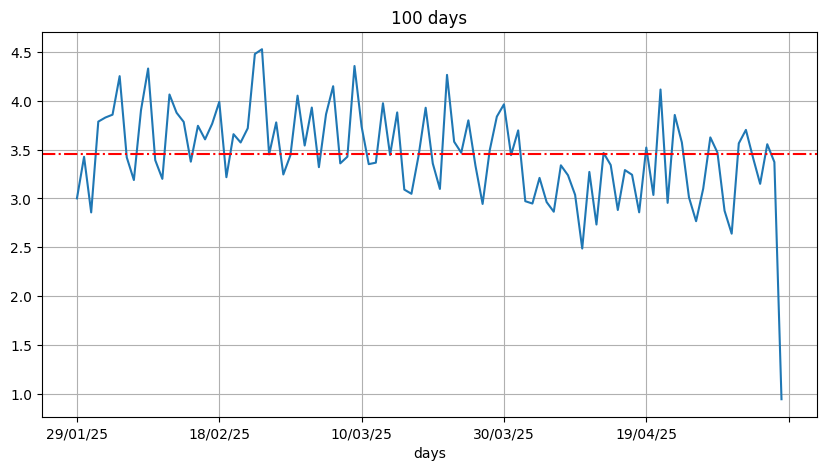

In [298]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [299]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 08:35:46, Minutes in day: 515


In [300]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [301]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:21.81


In [302]:
end - start

81.81028890609741

In [303]:
#df = conso_day
show_tranches()

1
2025-05-08 00:00:17.906843	2025-05-08 08:34:28.877843	8h 34m 10s 	942


# Today

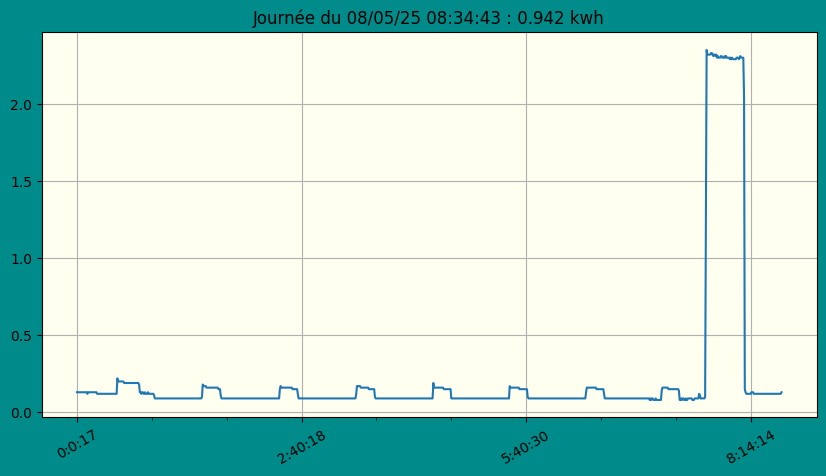

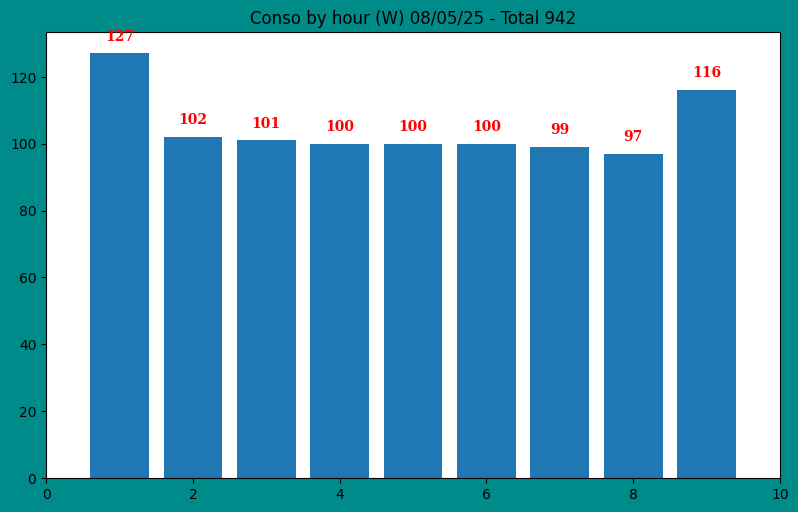

In [304]:
show(today,bgcolor='ivory')
conso_by_hour(today)

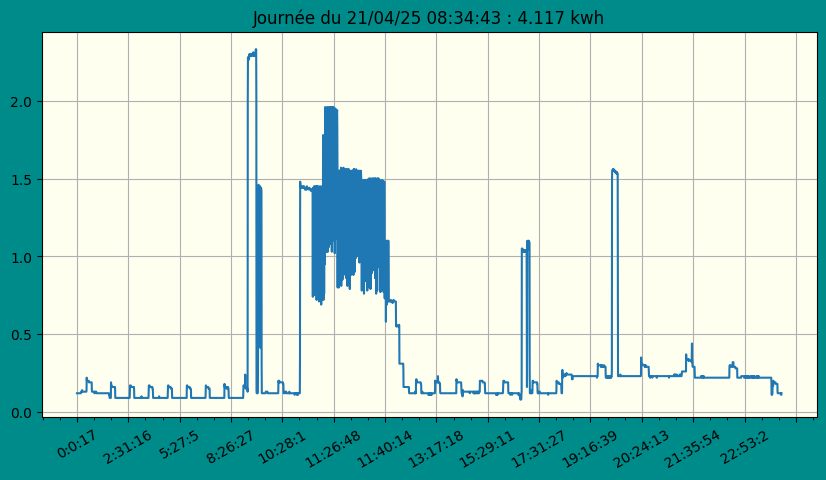

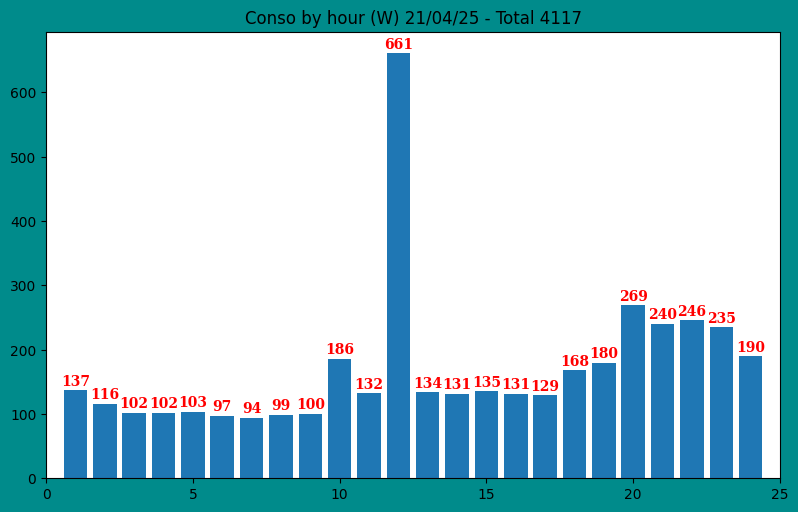

In [305]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4805)

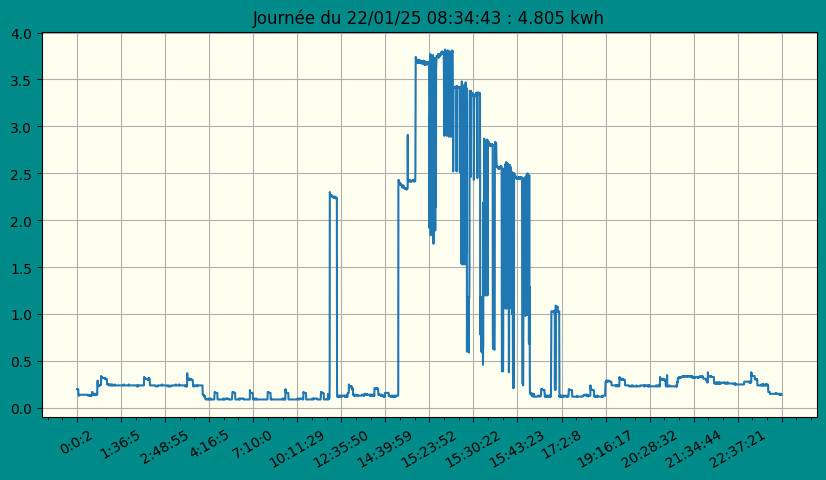

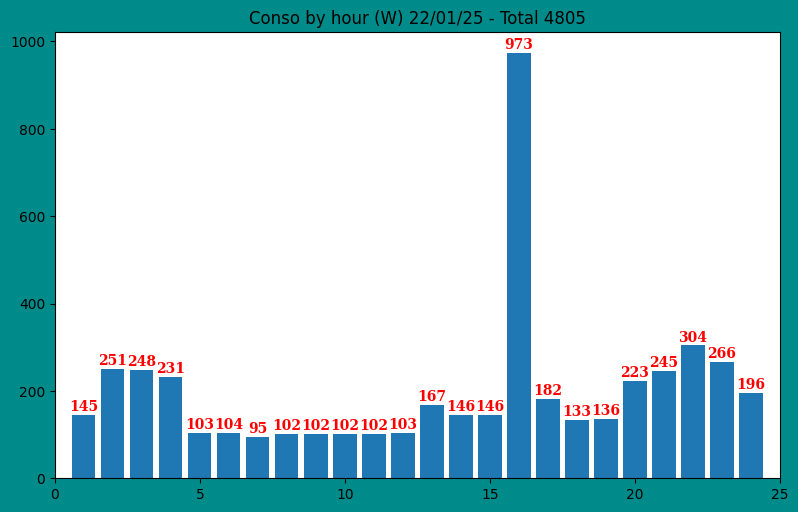

In [306]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

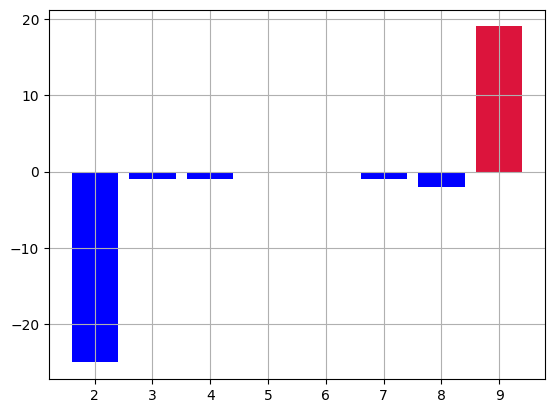

In [307]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

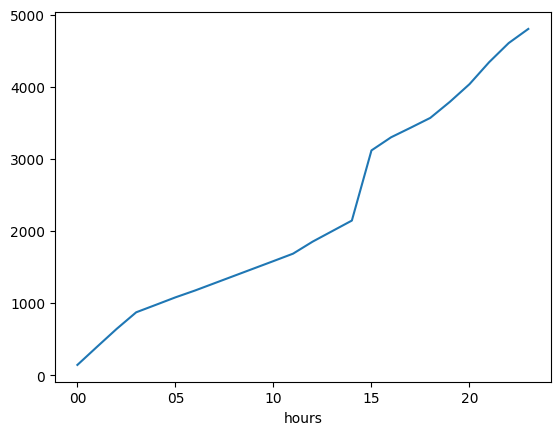

In [308]:
data.cumsum().plot()


<Axes: xlabel='hours'>

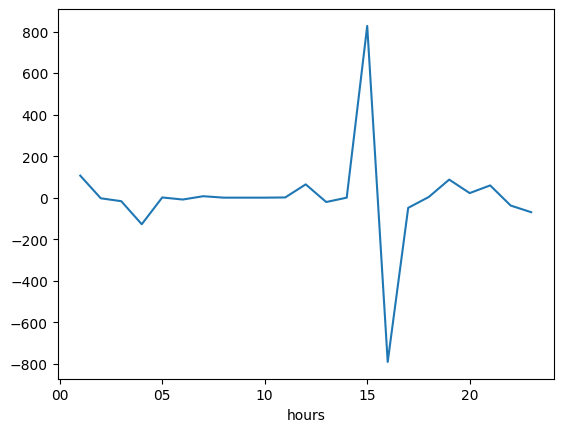

In [309]:
# evolution par heure
data.diff().plot()

In [310]:
data.diff().describe()

count     23.000000
mean       2.217391
std      248.849344
min     -791.000000
25%      -19.000000
50%        0.000000
75%       14.500000
max      827.000000
Name: kWh, dtype: float64

<Axes: >

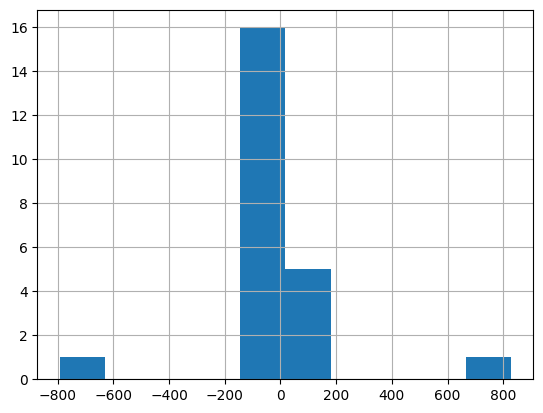

In [311]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [312]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [313]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

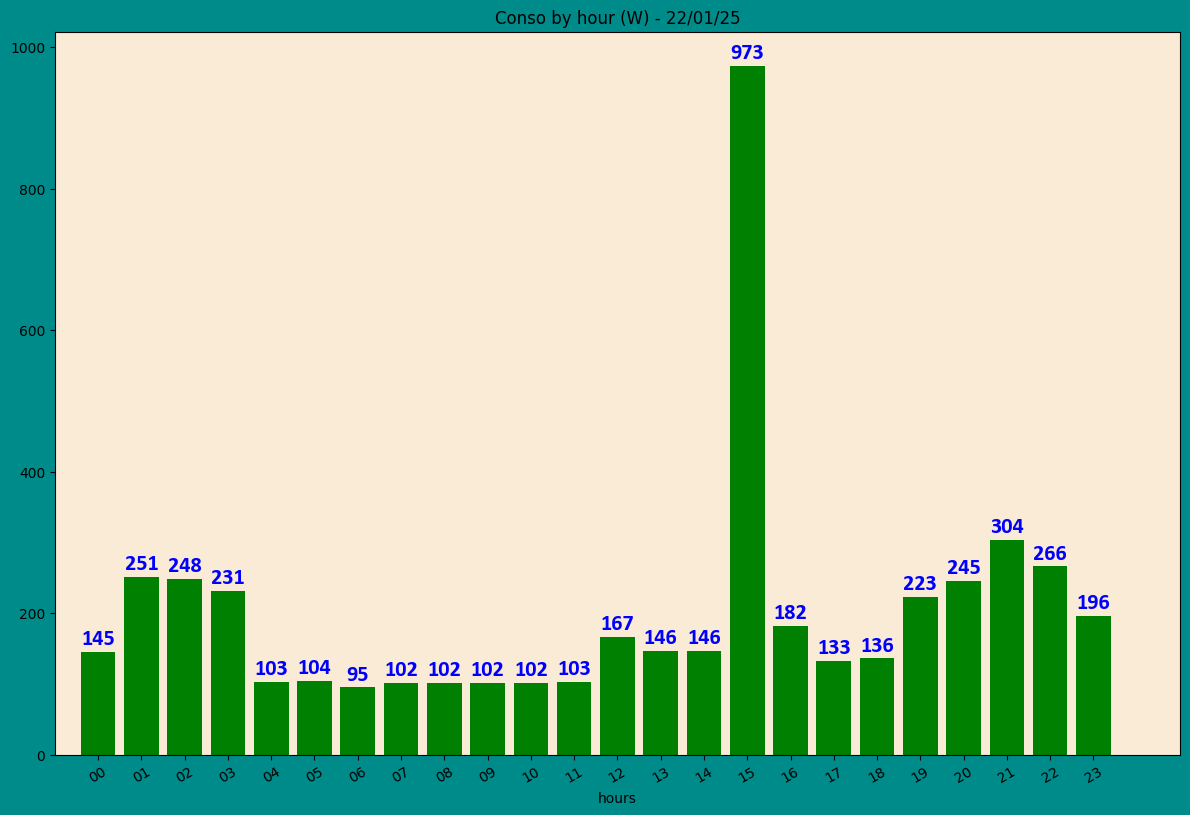

In [314]:
day,conso_byhour(day)

In [315]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


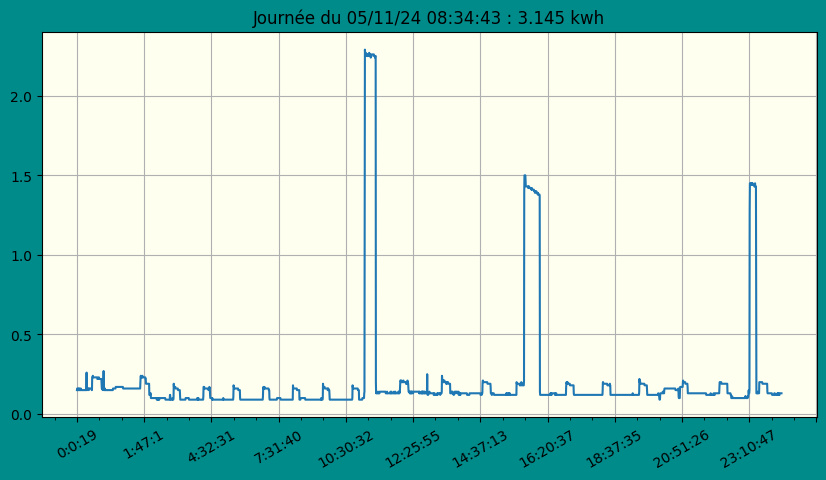

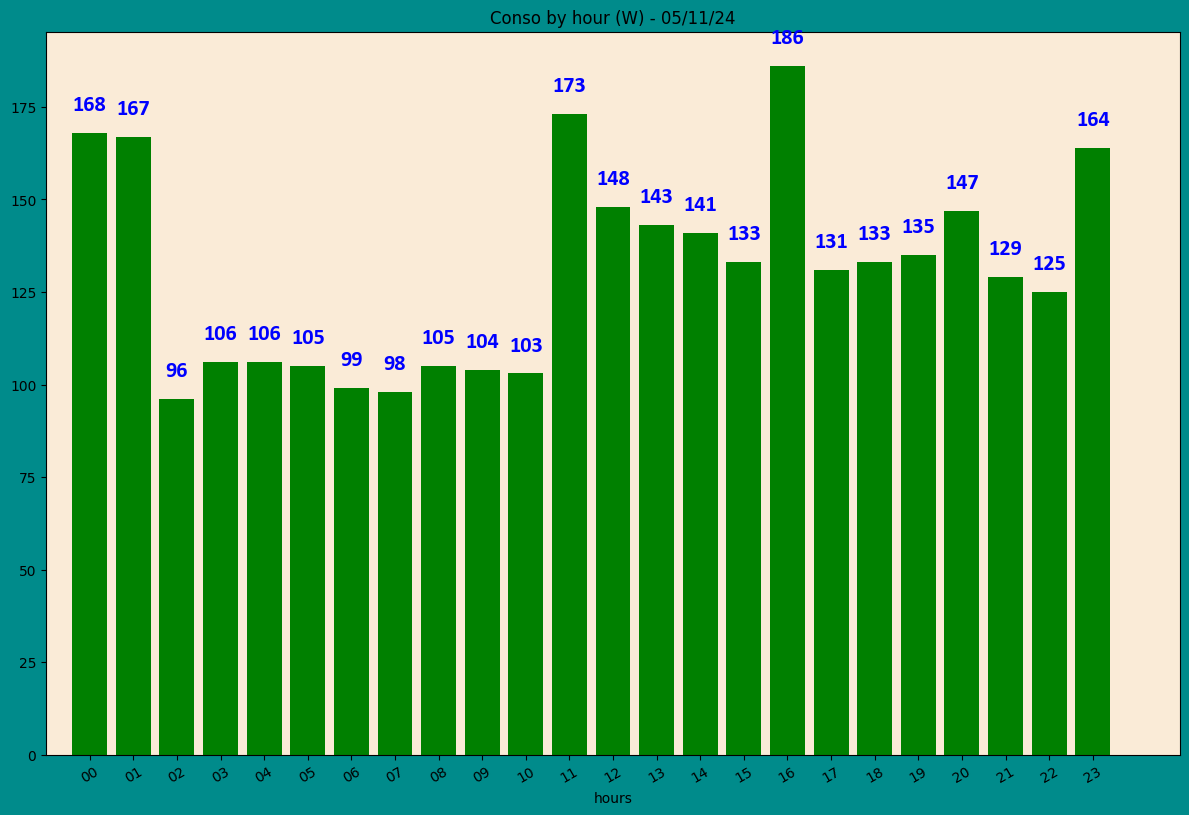

In [316]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [317]:
month

,day,hours,months,kWh
879897,01,00,2025-04,0.21
879898,01,00,2025-04,0.21
879899,01,00,2025-04,0.21
879900,01,00,2025-04,0.21
879901,01,00,2025-04,0.21
...,...,...,...,...
975649,30,23,2025-04,0.15
975650,30,23,2025-04,0.15
975651,30,23,2025-04,0.15
975652,30,23,2025-04,0.12


In [318]:
month.describe()


,kWh
count,95757.000000
mean,0.310161
std,0.548116
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

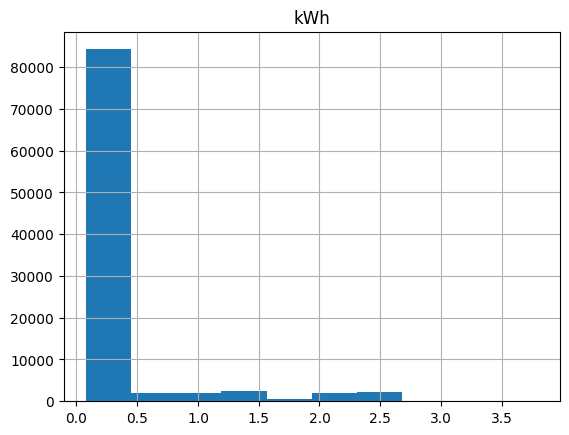

In [319]:
month.hist()

<Axes: >

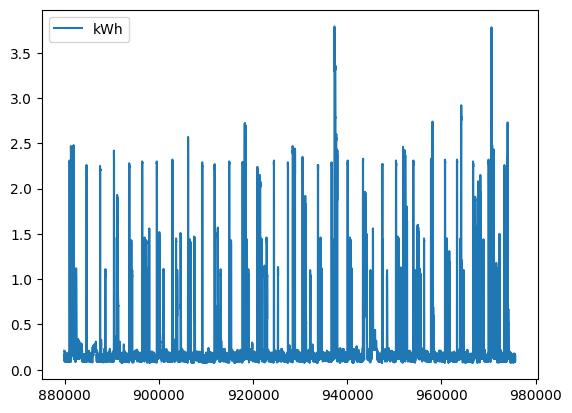

In [320]:
month.plot()

In [321]:
# index with max conso in this month
month.idxmax().kWh

np.int64(937279)

In [322]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       972780
hours     883377
months    879897
kWh       937279
dtype: int64

In [323]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [324]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
12/07/24 14      57      57    NaN   NaN
         15     146     203   89.0   NaN
         16     141     344   -5.0   NaN
         17     285     629  144.0   NaN
         18     143     772 -142.0   NaN
...             ...     ...    ...   ...
08/05/25 04     100     530    0.0   5.0
         05     100     630    0.0   6.0
         06      99     729   -1.0   7.0
         07      97     826   -2.0   8.0
         08     116     942   19.0   9.0

[7195 rows x 4 columns]

In [325]:
month

,day,hours,months,kWh
879897,01,00,2025-04,0.21
879898,01,00,2025-04,0.21
879899,01,00,2025-04,0.21
879900,01,00,2025-04,0.21
879901,01,00,2025-04,0.21
...,...,...,...,...
975649,30,23,2025-04,0.15
975650,30,23,2025-04,0.15
975651,30,23,2025-04,0.15
975652,30,23,2025-04,0.12


In [326]:
month.idxmax()


day       972780
hours     883377
months    879897
kWh       937279
dtype: int64

In [327]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 937279, dtype: object

In [328]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       165
          01       119
          02       105
          03       111
          04       110
          05       105
          06       105
          07       110
          08       109
          09       102
          10       172
          11       145
          12       148
          13       140
          14       194
          15       144
          16       176
          17       177
          18       152
          19       144
          20       150
          21       170
          22       219
          23       172
Name: kWh, dtype: int64

In [329]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

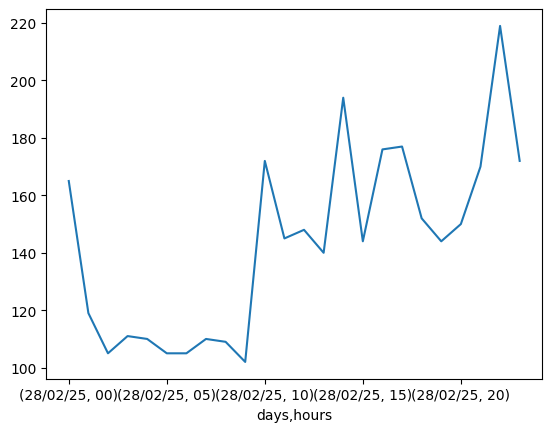

In [330]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [331]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [332]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [333]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [334]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB